**1. Using Different Algorithms to Predict WinPlacePerc**

Most of the code is borrowed from our code tutorials that are given in the CMPE 188 course. In addition, there are functions borrowed from Helge Bjorland & Stian Eide's An Interactive Data Science Tutorial, the code borrowed is credited in comments below next to the function definitions. Implementation of the LGBM algorithm is also referenced from the code in https://www.kaggle.com/rejasupotaro/effective-feature-engineering/notebook, found under the Discussion section of the Kaggle Competition.  Only the parameters are manipulated to fit and solve this problem.

By: Nikki Ravi, Yu Ning Hee

**2. Data Understanding**

**2.1 Import Libraries and Load Data**

In [41]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 

#Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('../input/train_V2.csv')
# train = train.dropna()
train.head()
# print(train.count())

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [42]:
test = pd.read_csv('../input/test_V2.csv')
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.00,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,0,2,1,361.90,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,0,0,0,0.00,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,0,0,0,0.00,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,0,3,1,60.06,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.0,4,0


**2.2 Setup helper Functions**

In [43]:
#####All these functions below are taken from: 
#####An Interactive Data Science Tutorial
#####Based on the Titanic competition on Kaggle
#####by Helge Bjorland & Stian Eide
def plot_correlation_map_visual( df ):
    corr = visualize.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
def plot_correlation_map( df ):
    corr = train.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

**2.3 Statistical Summaries and visualizations **

**2.3.1 Analyzing the Percentage of WinPlacePerc and Examine the Variables**

Based on the statistics of train and test as shown in the tables below, it is evident that both train and test sets had approximately the same mean of 0.92 and standard deviation of 1.5 for the kills feature. This gives us an indication that both of them have samples which are representative of the entire data set.

In [44]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [45]:
test.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
count,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06
mean,2.299524e-01,1.104360e+00,1.297406e+02,6.541500e-01,2.258147e-01,1.357999e+00,4.781403e+01,5.094502e+02,9.183569e-01,5.435855e-01,2.283917e+01,1.576554e+03,4.488918e+01,4.340615e+01,8.873689e+02,1.630189e-01,5.909889e+02,3.408690e-03,4.505277e+00,2.335829e-02,7.680798e-03,1.149258e+03,3.627590e+00,6.113582e+02
std,5.785920e-01,1.713828e+00,1.674371e+02,1.133690e+00,5.933918e-01,2.665694e+00,2.746275e+01,6.288322e+02,1.523761e+00,7.090114e-01,5.057429e+01,2.566299e+02,2.387529e+01,2.329498e+01,7.378231e+02,4.682340e-01,1.474899e+03,7.298342e-02,3.026267e+01,1.650875e-01,9.149580e-02,1.179668e+03,2.359042e+00,7.406629e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.400000e+01,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.366000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.541000e+02,2.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,8.416000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.436000e+03,3.000000e+01,3.000000e+01,1.442000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.795000e+02,3.000000e+00,0.000000e+00
75%,0.000000e+00,2.000000e+00,1.854000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.175000e+03,1.000000e+00,1.000000e+00,2.120000e+01,1.849000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,6.300000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.970000e+03,5.000000e+00,1.495000e+03
max,2.700000e+01,2.400000e+01,6.229000e+03,5.900000e+01,4.100000e+01,7.500000e+01,1.000000e+02,2.174000e+03,5.800000e+01,1.500000e+01,1.004000e+03,2.217000e+03,1.000000e+02,1.000000e+02,5.742000e+03,2.000000e+01,4.070000e+04,1.500000e+01,3.271000e+03,9.000000e+00,5.000000e+00,1.491000e+04,1.530000e+02,2.000000e+03


**2.3.2 Examine Relationships Between x and y Variables**
Examine the data, and try to consider the relationships between the x variables (assists, boosts, damageDealt etc.) and the target y variable (winPlacePerc). 

In [46]:
train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,1241,0,0,0.000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,0,0,0,0.000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,0,0,0,0.000,1318,duo,50,47,1491,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,0,0,0,0.000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,0,1,1,58.530,1424,solo-fpp,97,95,1560,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,0,1,1,18.440,1395,squad-fpp,28,28,1418,0,0.0000,0,0.000,0,0,34.70,1,0,0.0370
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,1262,0,0,0.000,1316,squad-fpp,28,28,-1,0,0.0000,0,0.000,0,0,13.50,1,1497,0.0000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,1000,0,0,0.000,1967,solo-fpp,96,92,-1,0,2004.0000,0,0.000,0,0,1089.00,6,1500,0.7368
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,0,0,0,0.000,1375,squad,28,27,1493,0,0.0000,0,0.000,0,0,799.90,4,0,0.3704
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.270,0,0,0,74,0,0,0,0.000,1930,squad,29,27,1349,0,0.0000,0,0.000,0,0,65.67,1,0,0.2143


**2.3.4 Heat Map of Correlation Between Variables**

From the heat map, although it is overwhelmed with information, we can tell that X features (boosts, damageDealt, heals, killPlace, kills, killStreaks, longestKill, walkDistance and weaponsAcquired) have some of the stronger relationships with Y target winPlacePerc.

We proceed to plot the more detailed heatmap below, that allows us to examine the strength of correlation between X features (boosts, damageDealt, heals, killPlace, kills, killStreaks, longestKill, walkDistance and weaponsAcquired) and Y target winPlacePerc.


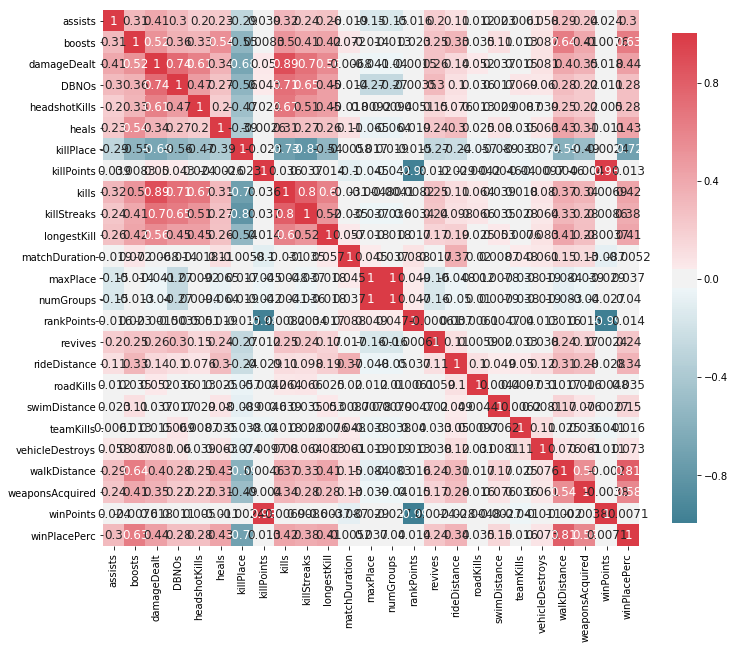

In [47]:
plot_correlation_map( train )

In [48]:
train2_1 = train.iloc[:100000, :]
train2 = train2_1.drop(columns=['groupId', 'matchId'])
train2.head()

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [49]:
#data = train.iloc[:,3:28].drop('matchType', axis=1)
train2_2 = train.loc[:,['winPlacePerc']]

train3 = train2.combine_first(train2_2)
train_filtered = train3.dropna()
data = train_filtered.loc[:, ['kills', 'maxPlace', 'numGroups', 'walkDistance', 'killPlace']] 
data_visualize = train_filtered.loc[:, ['boosts', 'damageDealt', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'walkDistance', 'weaponsAcquired']]
target = train_filtered.loc[:,['winPlacePerc']]
visualize = data_visualize.combine_first(target)

**3. Closer Examination of Heat Map of Correlation Between Variables and Data Preparation**

From the heat map, it is evident that boosts, killPlace, walkDistance and weaponsAcquired have the highest correlation with winPlacePerc.

**Assemble Final Datasets for Modelling**

Besides taking into account the heat map that shows us the variables with the strongest correlation with winPlacePerc, we decided to take into account the feature importance that was published in rejasupotaro's Discussion post on Kaggle (https://www.kaggle.com/rejasupotaro/effective-feature-engineering/notebook). 

Under the 'Feature Importances of Tree Models' section of the post, rejasupotaro displayed the feature importances output by the LightGBM, with ranking from highest to lowest of: killPlace, walkDistance, numGroups, maxPlace, kills, matchDuration, rideDistance and so on.

With that, we decided to take into consideration the features that the LightGBM model listed as most important, especially since most of them were also listed as highly correlated to winPlacePerc in the heat map.


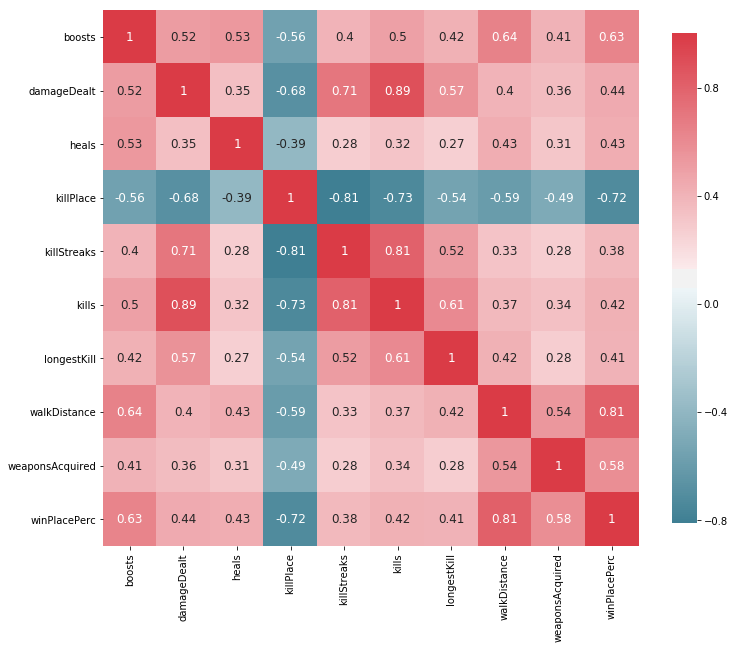

In [50]:
plot_correlation_map_visual( visualize )

In [51]:
data.head()

,kills,maxPlace,numGroups,walkDistance,killPlace
0,0.0,28.0,26.0,244.80,60.0
1,0.0,26.0,25.0,1434.00,57.0
2,0.0,50.0,47.0,161.80,47.0
3,0.0,31.0,30.0,202.70,75.0
4,1.0,97.0,95.0,49.75,45.0


In [52]:
target.head()

,winPlacePerc
0,0.4444
1,0.6400
2,0.7755
3,0.1667
4,0.1875


In [53]:
test_ = test.loc[:,['kills', 'maxPlace', 'numGroups', 'walkDistance', 'killPlace']]
#test_ = test_.fillna(0)
# imp_df = test_.values

In [54]:
from sklearn.impute import SimpleImputer
import numpy as np
imp_df = test_.values
imp = SimpleImputer(missing_values=np.nan, strategy = 'mean')
imp_array = imp.fit_transform(imp_df)
imp_df2= pd.DataFrame(data=imp_array)

**4. Modeling and Evaluation of Model Performance ** 

We selected a few different models to train, and observed which model performed better. We further split the training dataset into train and test sets, and used the train set to train the model, and verified the performance of the model using test set.

**Testing with KNRegressor  **

Not only did we tweak the parameters and their values to achieve the optimal model, but also we tweaked the X features we chose to input into the model. The X features that yield optimal performance were chosen through the process of combining the LightGBM's feature importance output and the heat map's variable correlation.

In [55]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import linear_model
X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0)

knn = KNeighborsRegressor(n_neighbors=45)#leaf_size=50) #linear_model.SGDClassifier(max_iter=100)
knn.fit(data,target)

#Print accuracy of the model
print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(knn.score(X_test, y_test)))

Accuracy on training set: 0.856
Accuracy on test set: 0.858


**Testing with LGBMRegressor**

After tweaking the X features to consist of the top few features that LGBMRegressor listed as important, our KNRegressor had its peak performance from our countless rounds of trials and testing. Hence, we decided to try to use the LGBMRegressor model to see if it would perform even better, since its feature importance ranking seemed to be on point.

After implementation, it indeed did perform significantly better than the KNRegressor as we had suspected.

In [56]:
###Code borrowed and adapted from https://www.kaggle.com/rejasupotaro/effective-feature-engineering/notebook
###rejasupotaro's Discussion post on Kaggle 
from lightgbm import LGBMRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(data,target)

print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Accuracy on training set: 0.917
Accuracy on test set: 0.919


In [57]:
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# model.fit(X_train[],y_train)

# print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
# print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

In [58]:
result = model.predict(test_)#knn.predict(test_)
id_col = test.loc[:, ['Id']]
id_col.columns = ['Id']

col = ['winPlacePerc']
res = pd.DataFrame(data = result, columns=col)
result2 = res.combine_first(id_col)

result2.to_csv('sample_submission.csv', index = False)

In [59]:
result2.describe()

,winPlacePerc
count,1.934174e+06
mean,4.719454e-01
std,2.935612e-01
min,-2.341592e-01
25%,2.098652e-01
50%,4.590589e-01
75%,7.483761e-01
max,1.084108e+00


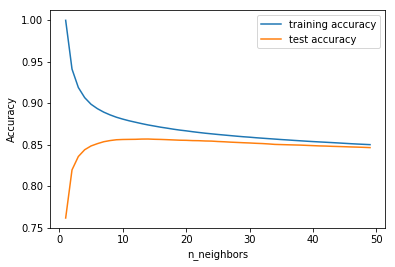

In [60]:
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0)

#accuracy sets
training_accuracy = []
test_accuracy = []

# try n_neighbors from 1 to 10.
neighbors_settings = range(1, 50)

for n_neighbors in neighbors_settings:
    # build the model
    knn2 = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn2.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn2.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(knn2.score(X_test, y_test))
    
#plot the results    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

In [61]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# RFC Parameters tunning 
RFC = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=10)

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
# Use voting classifier to combine the prediction power of all models
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(knn.score(X_test, y_test)))

In [ ]:
from scipy import stats
from matplotlib import pylab
import plotly.plotly as py
from numpy import arange,array,ones
import plotly
plotly.tools.set_credentials_file(username='Nikkr97', api_key='uA5XIqeeY2N4FapUCcDO')

# x = train['killPlace'].values
# y = train['winPlacePerc'].values

x = arange(1,12)
y = [1,3,5,7,9,11,13,15,17,19,21,23]

plt.scatter(x, y, color='black')
plt.axis([0, 100, 0, 1])
# plt.plot(test['killPlace'], result, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.plot(x,y,'o', x, line)
pylab.title('Linear Fit with Matplotlib')
ax = plt.gca()
# ax.set_axis_bgcolor((0.898, 0.898, 0.898))
fig = plt.gcf()
py.plot_mpl(fig, filename='linear-Fit-with-matplotlib')
plt.ylabel("winPlacePerc")
plt.xlabel("killPlace")

plt.show()